In [44]:
# Bibliotecas necessárias
from sidrapy import get_table
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt


# Preenchimento e Projeção de População
Este notebook tem como objetivo completar os dados de população:
1. Preenchendo os anos ausentes no histórico utilizando interpolação linear.
2. Projetando os valores para os anos futuros (2022, 2023, 2024) com regressão linear.
3. Inserindo os dados tratados no banco de dados.

As etapas são descritas e executadas separadamente para melhor entendimento.


In [55]:
# 1. Baixar dados da tabela 6579 (População residente estimada)
data = get_table(
    table_code="6579",  # Código da tabela no SIDRA
    territorial_level="3",  # Nível territorial (3 = Estados)
    ibge_territorial_code="all",  # Todos os estados
    period="2021,2020,2019,2018,2017,2016,2015,2014,2013,2012,2011,2010,2009,2008,2007,2006,2005,2004"
)

# 2. Converter para DataFrame
df = pd.DataFrame(data)

# 3. Filtrar e renomear as colunas necessárias
df_filtered = df[["D2C", "D1C", "V"]]  # "D2C" = Estado, "D1C" = Ano, "V" = População
df_filtered.columns = ["cd_ano", "cd_estado", "vl_populacao"]

# 4. Excluir linhas de totalização ou valores inválidos
df_filtered = df_filtered[~df_filtered["cd_estado"].str.contains("Unidade da Federação", na=False)]

# 5. Converter valores para tipos adequados
df_filtered["cd_estado"] = pd.to_numeric(df_filtered["cd_estado"], errors="coerce").astype(int)
df_filtered["cd_ano"] = pd.to_numeric(df_filtered["cd_ano"], errors="coerce").astype(int)
df_filtered["vl_populacao"] = pd.to_numeric(df_filtered["vl_populacao"], errors="coerce").astype(int)

# 6. Remover valores ausentes
df_filtered = df_filtered.dropna()

# Visualizar dados
df_filtered.head()


,cd_ano,cd_estado,vl_populacao
1,2021,11,1815278
2,2020,11,1796460
3,2019,11,1777225
4,2018,11,1757589
5,2017,11,1805788


## Preenchimento dos Anos Ausentes
Agora preencheremos os anos ausentes no histórico utilizando interpolação linear.
Os dados serão interpolados estado a estado para garantir consistência.


In [58]:
def preencher_anos_intermediarios(grupo):
    # Criar um DataFrame completo para o intervalo de anos
    todos_anos = range(int(grupo["cd_ano"].min()), int(grupo["cd_ano"].max()) + 1)
    df_completo = pd.DataFrame({"cd_ano": todos_anos})
    df_completo["cd_estado"] = grupo["cd_estado"].iloc[0]
    
    # Mesclar com os dados existentes
    df_completo = df_completo.merge(grupo, on=["cd_ano", "cd_estado"], how="left")
    
    # Preencher valores ausentes por interpolação
    df_completo["vl_populacao"] = df_completo["vl_populacao"].interpolate(method="linear").bfill().ffill()
    
    return df_completo

# Aplicar o preenchimento para cada estado
df_interpolado = pd.concat([preencher_anos_intermediarios(grupo) for _, grupo in df_filtered.groupby("cd_estado")])

# Visualizar dados preenchidos
df_interpolado.head(18)


,cd_ano,cd_estado,vl_populacao
0,2004,11,1562085.0
1,2005,11,1534594.0
2,2006,11,1562417.0
3,2007,11,1527991.0
4,2008,11,1493565.0
5,2009,11,1503928.0
6,2010,11,1540191.5
7,2011,11,1576455.0
8,2012,11,1590011.0
9,2013,11,1728214.0


## Projeção para Anos Futuros
Após completar o histórico, utilizaremos um modelo de regressão linear para projetar os valores para 2022, 2023 e 2024.


In [59]:
def projetar_populacao(grupo):
    # Treinar modelo de regressão linear
    X = grupo["cd_ano"].values.reshape(-1, 1)
    y = grupo["vl_populacao"].values
    modelo = LinearRegression()
    modelo.fit(X, y)
    
    # Projetar os anos futuros
    anos_futuros = np.array([2022, 2023, 2024]).reshape(-1, 1)
    projecoes = modelo.predict(anos_futuros)
    
    # Criar DataFrame com as projeções e converter para inteiros
    df_projecao = pd.DataFrame({
        "cd_ano": anos_futuros.flatten(),
        "cd_estado": grupo["cd_estado"].iloc[0],
        "vl_populacao": np.round(projecoes).astype(int)  # Arredondar e converter para inteiros
    })
    return df_projecao

# Aplicar a projeção para cada estado
df_projecoes = pd.concat([projetar_populacao(grupo) for _, grupo in df_interpolado.groupby("cd_estado")])

# Combinar histórico interpolado com projeções
df_completo = pd.concat([df_interpolado, df_projecoes]).sort_values(by=["cd_estado", "cd_ano"])

# Visualizar dados completos
df_completo.tail(21)


,cd_ano,cd_estado,vl_populacao
0,2004,53,2282049.0
1,2005,53,2333108.0
2,2006,53,2383784.0
3,2007,53,2470471.5
4,2008,53,2557159.0
5,2009,53,2606885.0
6,2010,53,2608441.5
7,2011,53,2609998.0
8,2012,53,2648532.0
9,2013,53,2789761.0


## Visualização dos Resultados
Agora visualizaremos os dados interpolados e projetados por estado utilizando gráficos.


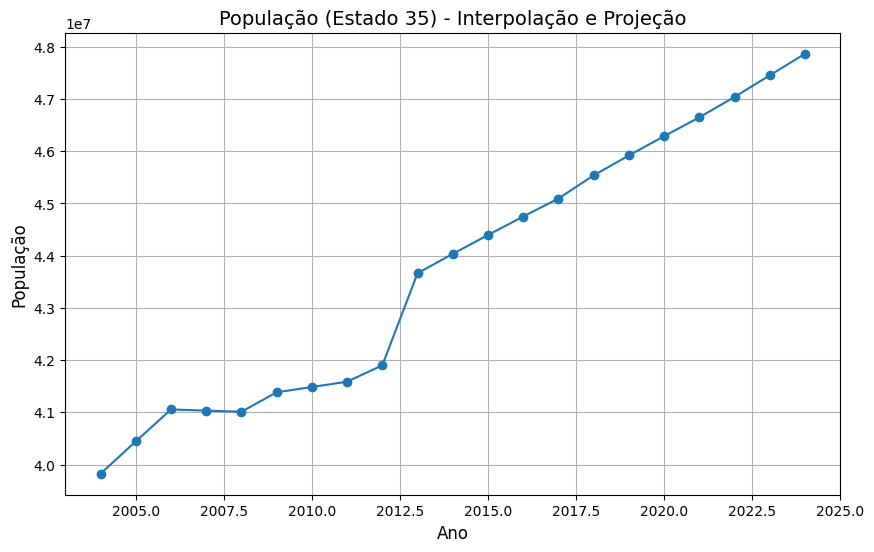

In [62]:
# Visualizar dados de um estado específico
estado_especifico = 35  # Alterar para o código do estado desejado
df_estado = df_completo[df_completo["cd_estado"] == estado_especifico]

plt.figure(figsize=(10, 6))
plt.plot(df_estado["cd_ano"], df_estado["vl_populacao"], marker="o")
plt.title(f"População (Estado {estado_especifico}) - Interpolação e Projeção", fontsize=14)
plt.xlabel("Ano", fontsize=12)
plt.ylabel("População", fontsize=12)
plt.grid()
plt.show()


## Gravação no Banco de Dados
Após completar os dados, os resultados serão gravados na tabela `t_sem_populacao` utilizando a operação `MERGE` para evitar duplicações.


In [63]:
from db.connection import DBConnection  # Certifique-se de ter essa classe configurada

# Conectar ao banco e inserir os dados processados
with DBConnection() as conn:
    cursor = conn.cursor()
    for _, row in df_completo.iterrows():
        cursor.execute(
            """
            MERGE INTO t_sem_populacao t
            USING (SELECT :cd_estado AS cd_estado, :cd_ano AS cd_ano, :vl_populacao AS vl_populacao FROM dual) s
            ON (t.cd_estado = s.cd_estado AND t.cd_ano = s.cd_ano)
            WHEN MATCHED THEN
                UPDATE SET t.vl_populacao = s.vl_populacao
            WHEN NOT MATCHED THEN
                INSERT (cd_estado, cd_ano, vl_populacao) VALUES (s.cd_estado, s.cd_ano, s.vl_populacao)
            """,
            {
                "cd_estado": int(row["cd_estado"]),  # Conversão explícita para int
                "cd_ano": int(row["cd_ano"]),       # Conversão explícita para int
                "vl_populacao": int(row["vl_populacao"])  # Conversão explícita para int
            }
        )
    conn.commit()

print("Dados históricos, interpolados e projeções inseridos ou atualizados com sucesso na tabela `t_sem_populacao`.")


Dados históricos, interpolados e projeções inseridos ou atualizados com sucesso na tabela `t_sem_populacao`.


# Conclusão
Os dados de população foram processados, interpolados, projetados e gravados no banco de dados com sucesso.
Agora, as análises podem ser realizadas diretamente a partir da tabela `t_sem_populacao`.
